In [1]:
import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import PReLU, LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D


channels = 3
lr_height = 64  # Low resolution height
lr_width = 64  # Low resolution width
lr_shape = (lr_height, lr_width, channels)
hr_height = lr_height * 4  # High resolution height
hr_width = lr_width * 4  # High resolution width
hr_shape = (hr_height, hr_width, channels)

# Number of residual blocks in the generator
n_residual_blocks = 16


def build_vgg():
    """
    Builds a pre-trained VGG19 model that outputs image features extracted at the
    third block of the model
    """
    vgg19 = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=hr_shape))
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False
        
    model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block3_conv4').output)
    model.trainable = False
    
    return model


def build_generator(gf=64, layer_half=None):
    def residual_block(layer_input, filters):
        """Residual block described in paper"""
        d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
        d = Activation('relu')(d)
        d = BatchNormalization(momentum=0.8)(d)
        d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
        d = BatchNormalization(momentum=0.8)(d)
        d = Add()([d, layer_input])
        return d

    def deconv2d(layer_input):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
        u = Activation('relu')(u)
        return u

    # Low resolution image input
    img_lr = Input(shape=lr_shape)

    # Pre-residual block
    c1 = Conv2D(gf, kernel_size=9, strides=1, padding='same')(img_lr)
    c1 = Activation('relu')(c1)

    # Propogate through residual blocks
    num_residual_blocks = n_residual_blocks
    if layer_half:
        num_residual_blocks = int(n_residual_blocks / 2)
        
    r = residual_block(c1, gf)
    for _ in range(num_residual_blocks - 1):
        r = residual_block(r, gf)

    # Post-residual block
    c2 = Conv2D(gf, kernel_size=3, strides=1, padding='same')(r)
    c2 = BatchNormalization(momentum=0.8)(c2)
    c2 = Add()([c2, c1])

    # Upsampling
    u1 = deconv2d(c2)
    u2 = deconv2d(u1)

    # Generate high resolution output
    gen_hr = Conv2D(channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

    return Model(img_lr, gen_hr)


def build_discriminator(df=64):
    def d_block(layer_input, filters, strides=1, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    # Input img
    d0 = Input(shape=hr_shape)

    d1 = d_block(d0, df, bn=False)
    d2 = d_block(d1, df, strides=2)
    d3 = d_block(d2, df * 2)
    d4 = d_block(d3, df * 2, strides=2)
    d5 = d_block(d4, df * 4)
    d6 = d_block(d5, df * 4, strides=2)
    d7 = d_block(d6, df * 8)
    d8 = d_block(d7, df * 8, strides=2)

    d9 = Dense(df * 16)(d8)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(d0, validity)

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Setup

In [3]:
from __future__ import print_function, division

import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image_dataset_from_directory

# from data_loader import DataLoader
# from models import build_generator, build_discriminator, build_vgg

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

# Set seed for comparison

In [4]:
tf.random.set_seed(2)

# Prepare Dataset

In [5]:
channels = 3
lr_height = 64  # Low resolution height
lr_width = 64  # Low resolution width
lr_shape = (lr_height, lr_width, channels)
hr_height = lr_height * 4  # High resolution height
hr_width = lr_width * 4  # High resolution width
hr_shape = (hr_height, hr_width, channels)

# Number of residual blocks in the generator
n_residual_blocks = 16

dataset_name = 'img_align_celeba'

In [6]:
train_dir = '/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages'

batch_size = 1
image_size = (hr_height, hr_width)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode=None,
    batch_size=batch_size,
    image_size=image_size,
    seed=1333,
    validation_split=0.2,
    subset="training",
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode=None,
    batch_size=batch_size,
    image_size=image_size,
    seed=1333,
    validation_split=0.2,
    subset="validation",
)

Found 17125 files.
Using 13700 files for training.
Found 17125 files.
Using 3425 files for validation.


# Preprocessing

In [7]:
def scaling(input_image):
    input_image = input_image / 127.5 - 1.
    return input_image


# Scale from (0, 255) to (-1, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

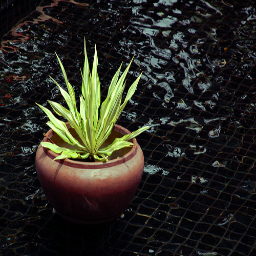

tf.Tensor(
[[[-0.963194   -0.9924692  -0.93176615]
  [-0.92185444 -0.9558018  -0.9190371 ]
  [-0.9866728  -0.9879749  -0.9983689 ]
  ...
  [-0.9848558  -0.96463585 -0.982183  ]
  [-0.9573223  -0.9643995  -0.94871324]
  [-0.9394935  -0.9668738  -0.95149994]]

 [[-0.9981478  -0.9884524  -0.98258007]
  [-0.9278488  -0.9252871  -0.92123115]
  [-1.         -0.98214066 -0.97801334]
  ...
  [-0.9163011  -0.9072104  -0.9063723 ]
  [-0.9647015  -0.98242855 -0.9773581 ]
  [-0.9620251  -0.9792546  -0.96862745]]

 [[-0.98972046 -0.9898437  -1.        ]
  [-0.8725052  -0.9013283  -0.9046371 ]
  [-0.9777916  -0.98678946 -0.9431278 ]
  ...
  [-0.81558204 -0.7102735  -0.8179746 ]
  [-0.9696165  -0.94912887 -0.96457446]
  [-0.98934627 -0.9789982  -0.9745251 ]]

 ...

 [[-0.86309457 -0.8661779  -0.86969614]
  [-0.8788383  -0.90909076 -0.90821075]
  [-0.9697497  -0.9200475  -0.87976277]
  ...
  [-0.93692964 -0.9511264  -0.9304557 ]
  [-0.95274204 -0.956633   -0.9390012 ]
  [-0.9730086  -0.9699215  -0.954

In [8]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))
        print(img)

In [9]:
def random_flip(input_image):
    if np.random.random() < 0.5:
        input_image = tf.image.flip_left_right(input_image)
    return input_image

train_ds = train_ds.map(random_flip)

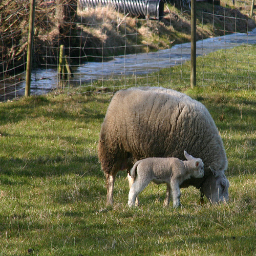

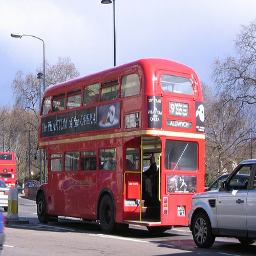

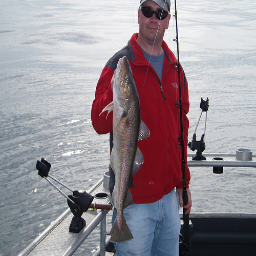

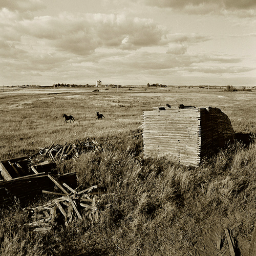

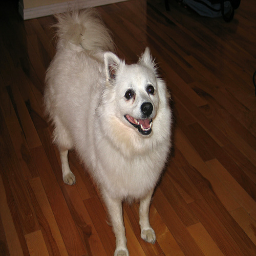

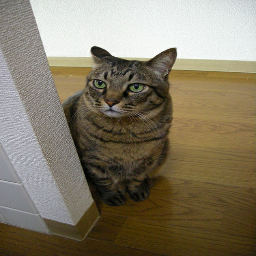

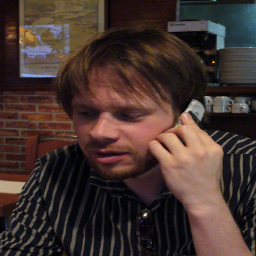

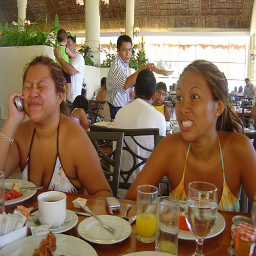

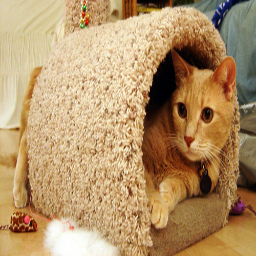

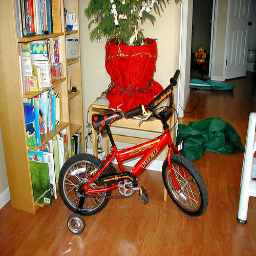

In [10]:
for batch in train_ds.take(10):
    for img in batch:
        display(array_to_img(img))

In [11]:
# resize input
def process_input(input, input_size):
    return tf.image.resize(input, [input_size, input_size], method="area")


train_ds = train_ds.map(
    lambda x: (process_input(x, lr_height), x)
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, lr_height), x)
)
valid_ds = valid_ds.prefetch(buffer_size=32)

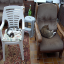

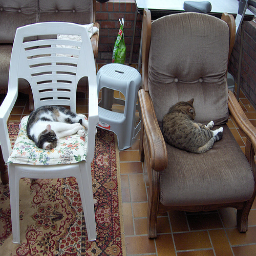

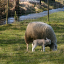

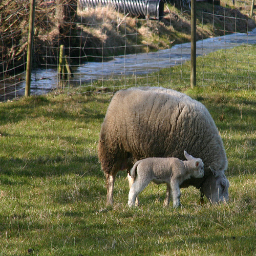

In [12]:
for batch in train_ds.take(2):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

# Set model

In [13]:
# optimizer = Adam(0.0002, 0.5)
generator_optimizer = Adam(0.0002, 0.5)
discriminator_optimizer = Adam(0.0002, 0.5)

df = 64
gf = 64

'''build vgg19'''
vgg = build_vgg()
vgg.trainable = False

'''build the discriminator'''
patch = int(hr_height / 2**4)
disc_patch = (patch, patch, 1)

discriminator = build_discriminator(df)

'''Build the generator''' 
generator = build_generator(gf)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [14]:
'''Build combined'''
# High res. and low res. images
img_hr = Input(shape=hr_shape)
img_lr = Input(shape=lr_shape)

# Generate high res. version from low res.
fake_hr = generator(img_lr)

# Extract image features of the generated img
fake_features = vgg(fake_hr)

# Discriminator determines validity of generated high res. images
validity = discriminator(fake_hr)

combined = Model([img_lr, img_hr], [validity, fake_features])

# loss function

In [15]:
mse = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy()

patch = int(hr_height / 2**4)
disc_patch = (patch, patch, 1)

In [16]:
def discriminator_loss(real_output, fake_output):
    
    valid = np.ones((batch_size,) + disc_patch)
    fake = np.zeros((batch_size,) + disc_patch)
         
    real_loss = cross_entropy(valid, real_output)
    fake_loss = cross_entropy(fake, fake_output)
    total_loss = 0.5 * (real_loss + fake_loss)
    return total_loss

In [17]:
def generator_loss(imgs_lr, imgs_hr):
    v, img_f = combined([imgs_lr, imgs_hr])
    image_features = vgg(imgs_hr)
    
    # The generators want the discriminators to label the generated images as real
    valid = np.ones((batch_size,) + disc_patch)
    
    vgg_loss = mse(img_f, image_features)
    gan_loss = 1e-3 * cross_entropy(v, valid)
    
    # Ensure both losses are of the same type
    vgg_loss = tf.cast(vgg_loss, tf.float32)
    
    loss = tf.add(gan_loss, vgg_loss)
    return loss


# Utils function

In [18]:
test_loader = iter(valid_ds.window(2))
image_folder_name = "new_srgan"

In [19]:
def sample_images(epoch):
    os.makedirs('images/%s' % image_folder_name, exist_ok=True)
    r, c = 2, 2

    imgs = next(test_loader)
    imgs_lr = np.array([img.numpy() for img in imgs[0]]).reshape((2,64,64,3))
    imgs_hr = np.array([img.numpy() for img in imgs[1]]).reshape((2,256,256,3))

    fake_hr = generator.predict(imgs_lr)

    # Rescale images 0 - 1
    imgs_lr = 0.5 * imgs_lr + 0.5
    fake_hr = 0.5 * fake_hr + 0.5
    imgs_hr = 0.5 * imgs_hr + 0.5

    # Save generated images and the high resolution originals
    titles = ['Generated', 'Original']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for row in range(r):
        for col, image in enumerate([fake_hr, imgs_hr]):
            axs[row, col].imshow(image[row])
            axs[row, col].set_title(titles[col])
            axs[row, col].axis('off')
        cnt += 1
    fig.savefig("images/%s/%d.png" % (image_folder_name, epoch))
    plt.close()

    # Save low resolution images for comparison
    for i in range(r):
        fig = plt.figure()
        plt.imshow(imgs_lr[i])
        fig.savefig('images/%s/%d_lowres%d.png' % (image_folder_name, epoch, i))
        plt.close()

# Train the model

In [20]:
@tf.function
def train_step(data):

    imgs_lr, imgs_hr = data
        
    with tf.GradientTape() as disc_tape:
        fake_hr = generator(imgs_lr, training=True)

        real_output = discriminator(imgs_hr, training=True)
        fake_output = discriminator(fake_hr, training=True)
            
        psnr = tf.image.psnr(fake_hr, imgs_hr, max_val=1.0)
        ssim = tf.image.ssim(fake_hr, imgs_hr, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
        
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        
    with tf.GradientTape() as gen_tape:
        gen_loss = generator_loss(imgs_lr, imgs_hr)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
    return gen_loss, disc_loss, psnr, ssim

# Train using modified ds

In [21]:
def train(epochs, batch_size=1, sample_interval=50):

    train_iter = iter(train_ds)
    
    start_time = datetime.datetime.now()
    psnr_list = []
    ssim_list = []

    for epoch in range(epochs):
        batch = next(train_iter)
        g_loss, d_loss, psnr, ssim = train_step(batch)
        
        psnr_list.append(psnr)
        ssim_list.append(ssim)
        
        elapsed_time = datetime.datetime.now() - start_time
        # Plot the progress
        if epoch % 10 == 0:
            print ("%d time: %s " % (epoch, elapsed_time), end=' ')
            tf.print(tf.strings.format("g_loss: {}, d_loss: {}, psnr: {}, ssim: {}", (g_loss, d_loss, np.mean(psnr_list), np.mean(ssim_list))), output_stream=sys.stdout)
            psnr_list = []
            ssim_list = []

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

In [22]:
train(epochs = 10000)

0 time: 0:00:30.534866  g_loss: 294.965271, d_loss: 0.796358287, psnr: 4.43463087, ssim: 0.0069719241
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
10 time: 0:00:38.218738  g_loss: 257.558441, d_loss: 0.210061073, psnr: 2.56467319, ssim: 0.00744050601
20 time: 0:00:39.586418  g_loss: 215.00058, d_loss: 0.0374259129, psnr: 0.904110134, ssim: -0.0181428958
30 time: 0:00:40.947557  g_loss: 135.155594, d_loss: 0.0314291343, psnr: 0.624024093, ssim: 0.00420268159
40 time: 0:00:42.309901  g_loss: 137.787888, d_loss: 0.116231307, psnr: 0.82088536, ssim: -0.055598855
50 time: 0:00:43.681599  g_loss: 204.339661, d_loss: 0.0133600198, psnr: 1.39674544, ssim: -0.0149788689
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
60 time: 0:00:45.700838  g_loss: 150.782578, d_loss: 0.011893603, psnr: 0.73942256, ssim: -0.0917627364
70 time: 0:00:47.065995  g_loss: 190.537354, d_loss: 0.00983663555, psnr: 3.0081706, ssim: -0.0189086422
80 time: 0:00:48.424560  g_loss: 98.882431, d_loss: 0.00327357207, psnr: 2.22192764, ssim: -

In [23]:
generator.save('new_srgan_epoch3000_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Comparison saved to validation_comparison.png


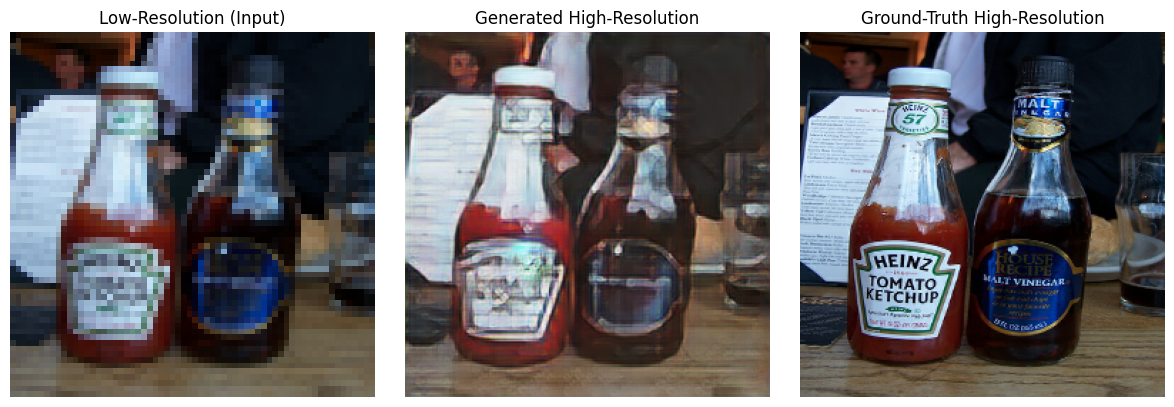

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def generate_and_compare(generator, valid_ds, output_path):
    # Fetch a batch of validation images
    for lr_images, hr_images in valid_ds.take(1):  # Take one batch
        break
    
    # Ensure images have the correct dimensions
    lr_images = np.array(lr_images)
    hr_images = np.array(hr_images)
    
    # Check if the data is single-dimensional
    if len(lr_images.shape) == 1:
        lr_images = np.expand_dims(lr_images, axis=0)
    if len(hr_images.shape) == 1:
        hr_images = np.expand_dims(hr_images, axis=0)
    
    # Use the generator to create HR images
    gen_hr_images = generator.predict(lr_images)
    
    # Rescale images for visualization
    lr_images = (lr_images + 1.0) / 2.0  # Rescale to [0, 1]
    hr_images = (hr_images + 1.0) / 2.0  # Rescale to [0, 1]
    gen_hr_images = (gen_hr_images + 1.0) / 2.0  # Rescale to [0, 1]
    
    # Create a comparison plot
    num_images = min(3, len(lr_images))  # Display up to 3 comparisons
    fig, axs = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    
    if num_images == 1:  # Adjust if there's only one image
        axs = np.expand_dims(axs, axis=0)
    
    for i in range(num_images):
        # Low-resolution image
        axs[i, 0].imshow(lr_images[i])
        axs[i, 0].set_title("Low-Resolution (Input)")
        axs[i, 0].axis("off")
        
        # Generated high-resolution image
        axs[i, 1].imshow(gen_hr_images[i])
        axs[i, 1].set_title("Generated High-Resolution")
        axs[i, 1].axis("off")
        
        # Ground-truth high-resolution image
        axs[i, 2].imshow(hr_images[i])
        axs[i, 2].set_title("Ground-Truth High-Resolution")
        axs[i, 2].axis("off")
    
    plt.tight_layout()
    plt.savefig(output_path)
    print(f"Comparison saved to {output_path}")
    plt.show()

# Example usage
output_path = "validation_comparison.png"  # Path to save the comparison
generate_and_compare(generator, valid_ds, output_path)
